# Train a JointVAE model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from viz.visualize import Visualizer
use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # change to your device

#### Prepare data list

In [4]:
!ls data

dress_dresslen_train_test_splits.json	dress_sleeve_train_test_splits.json
dress_sleevelen_train_test_splits.json


In [5]:
import json
with open("./data/dress_dresslen_train_test_splits.json", "r") as infile:
    data_dict = json.load(infile)

In [6]:
data_dict.keys()

dict_keys(['X_train_1', 'y_train_1', 'X_test_1', 'y_test_1', 'X_train_2', 'y_train_2', 'X_test_2', 'y_test_2', 'X_train_3', 'y_train_3', 'X_test_3', 'y_test_3', 'X_train_4', 'y_train_4', 'X_test_4', 'y_test_4', 'X_train_5', 'y_train_5', 'X_test_5', 'y_test_5', 'X_train_6', 'y_train_6', 'X_test_6', 'y_test_6', 'X_train_7', 'y_train_7', 'X_test_7', 'y_test_7', 'X_train_8', 'y_train_8', 'X_test_8', 'y_test_8', 'X_train_9', 'y_train_9', 'X_test_9', 'y_test_9', 'X_train_10', 'y_train_10', 'X_test_10', 'y_test_10'])

In [7]:
data_dict['X_train_1'][:5]

['/2/8/2893552_3773662.jpg',
 '/2/9/2982376_3889235.jpg',
 '/2/7/2783355_3578973.jpg',
 '/2/9/2974380_3918638.jpg',
 '/2/8/2886740_3675612.jpg']

#### Create list of image paths

In [8]:
!python -V

Python 3.6.5


In [9]:
image_paths_train = []
image_paths_test = []

root_data_dir = "/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables"

for key, val in data_dict.items():
    if 'X_train' in key:
        image_paths_train.extend([root_data_dir + imgpath for imgpath in val])
    elif 'X_test' in key:
        image_paths_test.extend([root_data_dir + imgpath for imgpath in val])

print(f"Number of train image paths: {len(image_paths_train):,d}")
print(f"Number of test image paths: {len(image_paths_test):,d}")
print()
print("Sample paths:")
print(image_paths_train[0])
print(image_paths_train[-1])
print(image_paths_test[0])
print(image_paths_test[-1])

Number of train image paths: 167,742
Number of test image paths: 18,638

Sample paths:
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/8/2893552_3773662.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/6/2683298_3676896.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/4/2431229_3158108.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/5/2569101_3223742.jpg


In [10]:
#from utils.dataloaders import get_mnist_dataloaders, get_fashion_mnist_dataloaders
#train_loader, test_loader = get_mnist_dataloaders(batch_size=64)
#train_loader, test_loader = get_fashion_mnist_dataloaders(batch_size=64)

In [11]:
from torchvision import transforms
from utils.dataloaders_custom import get_imagelist_dataloader, ImageListDataset

BATCH_SIZE = 32

#composed = transforms.Compose([transforms.Resize((260,260)), transforms.ToTensor()])
composed = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])

train_dataset = ImageListDataset(image_paths_train, transform=composed)
test_dataset = ImageListDataset(image_paths_test, transform=composed)

train_loader = get_imagelist_dataloader(batch_size=BATCH_SIZE, dataset_object=train_dataset)
test_loader = get_imagelist_dataloader(batch_size=BATCH_SIZE, dataset_object=test_dataset)

### Define latent distribution of the model

In [12]:
# Latent distribution will be joint distribution of 10 gaussian normal distributions
# and one 10 dimensional Gumbel Softmax distribution
latent_spec = {'cont': 10,
               'disc': [10]}

### Build a model

In [13]:
#from jointvae.models_v1 import VAE
from jointvae.models import VAE

#model = VAE(latent_spec=latent_spec, img_size=(3, 260, 260), use_cuda=use_cuda)
model = VAE(latent_spec=latent_spec, img_size=(3, 64, 64), use_cuda=use_cuda)

In [14]:
print(model)

VAE(
  (img_to_features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (features_to_hidden): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
  )
  (fc_mean): Linear(in_features=256, out_features=10, bias=True)
  (fc_log_var): Linear(in_features=256, out_features=10, bias=True)
  (fc_alphas): ModuleList(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
  (latent_to_features): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
  )
  (features_to_img): Sequential(
    (0): ConvTranspose

### Train the model

In [15]:
from torch import optim

# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4, amsgrad=True) # added amsgrad # orig lr 5e-4

In [16]:
from jointvae.training import Trainer

# Define the capacities
# Continuous channels
cont_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0

# Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,
                  disc_capacity=disc_capacity,
                 use_cuda=use_cuda)

#### Initialize visualizer

In [17]:
# Build a visualizer which will be passed to trainer to visualize progress during training
viz = Visualizer(model)

In [18]:
# Train model for 10 epochs
# Note this should really be a 100 epochs and trained on a GPU, but this is just to demo

trainer.train(train_loader, epochs=10, save_training_gif=('./training_rd1.gif', viz))

0/167742	Loss: 2836.089
1000/167742	Loss: 2435.052
2000/167742	Loss: 1539.812
3000/167742	Loss: 1419.947
4000/167742	Loss: 1387.930
5000/167742	Loss: 1355.027
6000/167742	Loss: 1350.809
7000/167742	Loss: 1339.796
8000/167742	Loss: 1367.289
9000/167742	Loss: 1345.060
10000/167742	Loss: 1336.565
11000/167742	Loss: 1332.512
12000/167742	Loss: 1315.887
13000/167742	Loss: 1327.997
14000/167742	Loss: 1331.076
15000/167742	Loss: 1310.714
16000/167742	Loss: 1320.737
17000/167742	Loss: 1313.769
18000/167742	Loss: 1289.622
19000/167742	Loss: 1284.920
20000/167742	Loss: 1285.379
21000/167742	Loss: 1294.884
22000/167742	Loss: 1280.471
23000/167742	Loss: 1280.193
24000/167742	Loss: 1271.653
25000/167742	Loss: 1266.280
26000/167742	Loss: 1287.138
27000/167742	Loss: 1248.366
28000/167742	Loss: 1252.842
29000/167742	Loss: 1242.234
30000/167742	Loss: 1246.277
31000/167742	Loss: 1262.468
32000/167742	Loss: 1247.468
33000/167742	Loss: 1248.933
34000/167742	Loss: 1236.049
35000/167742	Loss: 1232.997
36000

122000/167742	Loss: 1154.110
123000/167742	Loss: 1159.725
124000/167742	Loss: 1156.037
125000/167742	Loss: 1145.645
126000/167742	Loss: 1151.117
127000/167742	Loss: 1158.272
128000/167742	Loss: 1131.610
129000/167742	Loss: 1144.172
130000/167742	Loss: 1144.308
131000/167742	Loss: 1144.943
132000/167742	Loss: 1150.766
133000/167742	Loss: 1156.026
134000/167742	Loss: 1159.668
135000/167742	Loss: 1140.138
136000/167742	Loss: 1152.661
137000/167742	Loss: 1150.571
138000/167742	Loss: 1133.499
139000/167742	Loss: 1160.535
140000/167742	Loss: 1142.486
141000/167742	Loss: 1145.103
142000/167742	Loss: 1146.185
143000/167742	Loss: 1152.941
144000/167742	Loss: 1160.805
145000/167742	Loss: 1132.364
146000/167742	Loss: 1140.348
147000/167742	Loss: 1144.176
148000/167742	Loss: 1148.573
149000/167742	Loss: 1140.276
150000/167742	Loss: 1153.005
151000/167742	Loss: 1144.512
152000/167742	Loss: 1146.774
153000/167742	Loss: 1133.058
154000/167742	Loss: 1142.521
155000/167742	Loss: 1146.512
156000/167742	

74000/167742	Loss: 1127.029
75000/167742	Loss: 1120.768
76000/167742	Loss: 1116.459
77000/167742	Loss: 1121.201
78000/167742	Loss: 1131.422
79000/167742	Loss: 1119.493
80000/167742	Loss: 1134.051
81000/167742	Loss: 1117.189
82000/167742	Loss: 1128.083
83000/167742	Loss: 1142.418
84000/167742	Loss: 1125.510
85000/167742	Loss: 1127.000
86000/167742	Loss: 1131.192
87000/167742	Loss: 1140.303
88000/167742	Loss: 1134.917
89000/167742	Loss: 1119.368
90000/167742	Loss: 1130.091
91000/167742	Loss: 1123.284
92000/167742	Loss: 1125.532
93000/167742	Loss: 1112.143
94000/167742	Loss: 1139.532
95000/167742	Loss: 1136.690
96000/167742	Loss: 1116.910
97000/167742	Loss: 1124.848
98000/167742	Loss: 1122.202
99000/167742	Loss: 1116.118
100000/167742	Loss: 1123.055
101000/167742	Loss: 1128.744
102000/167742	Loss: 1124.408
103000/167742	Loss: 1120.495
104000/167742	Loss: 1120.685
105000/167742	Loss: 1107.929
106000/167742	Loss: 1121.863
107000/167742	Loss: 1125.349
108000/167742	Loss: 1124.873
109000/1677

25000/167742	Loss: 1112.003
26000/167742	Loss: 1126.023
27000/167742	Loss: 1125.272
28000/167742	Loss: 1123.226
29000/167742	Loss: 1107.735
30000/167742	Loss: 1119.249
31000/167742	Loss: 1138.562
32000/167742	Loss: 1110.771
33000/167742	Loss: 1112.038
34000/167742	Loss: 1115.969
35000/167742	Loss: 1126.575
36000/167742	Loss: 1119.558
37000/167742	Loss: 1121.662
38000/167742	Loss: 1108.857
39000/167742	Loss: 1112.847
40000/167742	Loss: 1096.214
41000/167742	Loss: 1130.695
42000/167742	Loss: 1123.297
43000/167742	Loss: 1110.115
44000/167742	Loss: 1098.163
45000/167742	Loss: 1119.140
46000/167742	Loss: 1108.378
47000/167742	Loss: 1128.703
48000/167742	Loss: 1129.194
49000/167742	Loss: 1112.110
50000/167742	Loss: 1109.822
51000/167742	Loss: 1107.104
52000/167742	Loss: 1093.000
53000/167742	Loss: 1113.062
54000/167742	Loss: 1120.492
55000/167742	Loss: 1109.534
56000/167742	Loss: 1120.245
57000/167742	Loss: 1124.653
58000/167742	Loss: 1113.335
59000/167742	Loss: 1119.505
60000/167742	Loss: 1

145000/167742	Loss: 1109.257
146000/167742	Loss: 1109.248
147000/167742	Loss: 1124.685
148000/167742	Loss: 1106.847
149000/167742	Loss: 1125.048
150000/167742	Loss: 1103.747
151000/167742	Loss: 1104.223
152000/167742	Loss: 1106.162
153000/167742	Loss: 1111.951
154000/167742	Loss: 1111.711
155000/167742	Loss: 1108.519
156000/167742	Loss: 1116.602
157000/167742	Loss: 1097.240
158000/167742	Loss: 1099.829
159000/167742	Loss: 1100.626
160000/167742	Loss: 1109.038
161000/167742	Loss: 1116.955
162000/167742	Loss: 1123.431
163000/167742	Loss: 1103.313
164000/167742	Loss: 1105.372
165000/167742	Loss: 1107.325
166000/167742	Loss: 1115.034
167000/167742	Loss: 1118.370
Epoch: 7 Average loss: 1112.67
0/167742	Loss: 1131.110
1000/167742	Loss: 1114.833
2000/167742	Loss: 1113.762
3000/167742	Loss: 1123.437
4000/167742	Loss: 1109.593
5000/167742	Loss: 1110.558
6000/167742	Loss: 1104.111
7000/167742	Loss: 1110.569
8000/167742	Loss: 1120.645
9000/167742	Loss: 1115.309
10000/167742	Loss: 1123.103
11000/1

98000/167742	Loss: 1112.905
99000/167742	Loss: 1089.779
100000/167742	Loss: 1111.497
101000/167742	Loss: 1098.134
102000/167742	Loss: 1100.593
103000/167742	Loss: 1094.735
104000/167742	Loss: 1104.511
105000/167742	Loss: 1092.694
106000/167742	Loss: 1093.056
107000/167742	Loss: 1102.257
108000/167742	Loss: 1103.680
109000/167742	Loss: 1090.164
110000/167742	Loss: 1091.174
111000/167742	Loss: 1107.252
112000/167742	Loss: 1107.233
113000/167742	Loss: 1095.526
114000/167742	Loss: 1107.128
115000/167742	Loss: 1101.654
116000/167742	Loss: 1107.122
117000/167742	Loss: 1109.295
118000/167742	Loss: 1104.297
119000/167742	Loss: 1107.230
120000/167742	Loss: 1102.261
121000/167742	Loss: 1100.476
122000/167742	Loss: 1102.043
123000/167742	Loss: 1109.978
124000/167742	Loss: 1099.865
125000/167742	Loss: 1092.187
126000/167742	Loss: 1110.801
127000/167742	Loss: 1099.415
128000/167742	Loss: 1095.490
129000/167742	Loss: 1099.621
130000/167742	Loss: 1113.612
131000/167742	Loss: 1094.279
132000/167742	Lo

Epoch: 10 Average loss: 1104.19


### Visualize

In [37]:
!ls

data				requirements.txt
dataloading_pytorch_test.ipynb	sample_images
imgs				statedict_jvae_fmnist_oct292018.pth
jointvae			trained_models
jvae_fmnist_oct292018.pth	training.gif
latent_traversals.py		training_rd1.gif
load_model.ipynb		train_model.ipynb
main.py				train_model_realdata_306_260_v1.ipynb
__pycache__			train_model_realdata_64_v1.ipynb
RandomUtilsandTests.ipynb	utils
README.md			viz


### Colormaps
Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

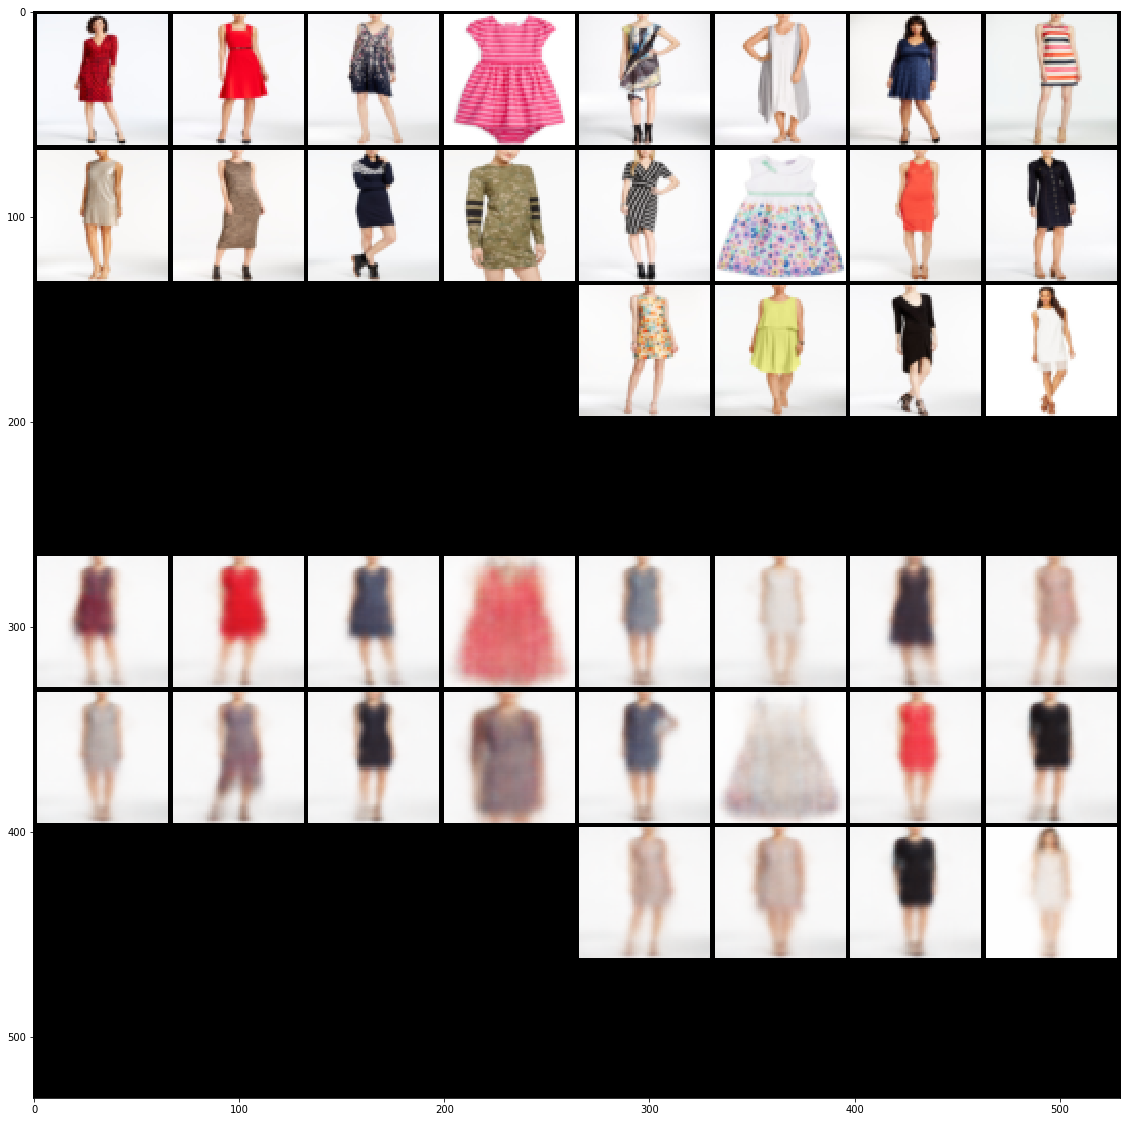

In [95]:
# Plot reconstructions
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Get a batch of data
for batch, labels in test_loader:
    break

# Reconstruct data using Joint-VAE model
recon = viz.reconstructions(batch)

plt.figure(figsize=(20,20))
#np.transpose(recon.numpy(), (2,1,0))
plt.imshow(np.rot90(np.transpose(recon.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/64/e10_b20_reconstructions.png",dpi=600)

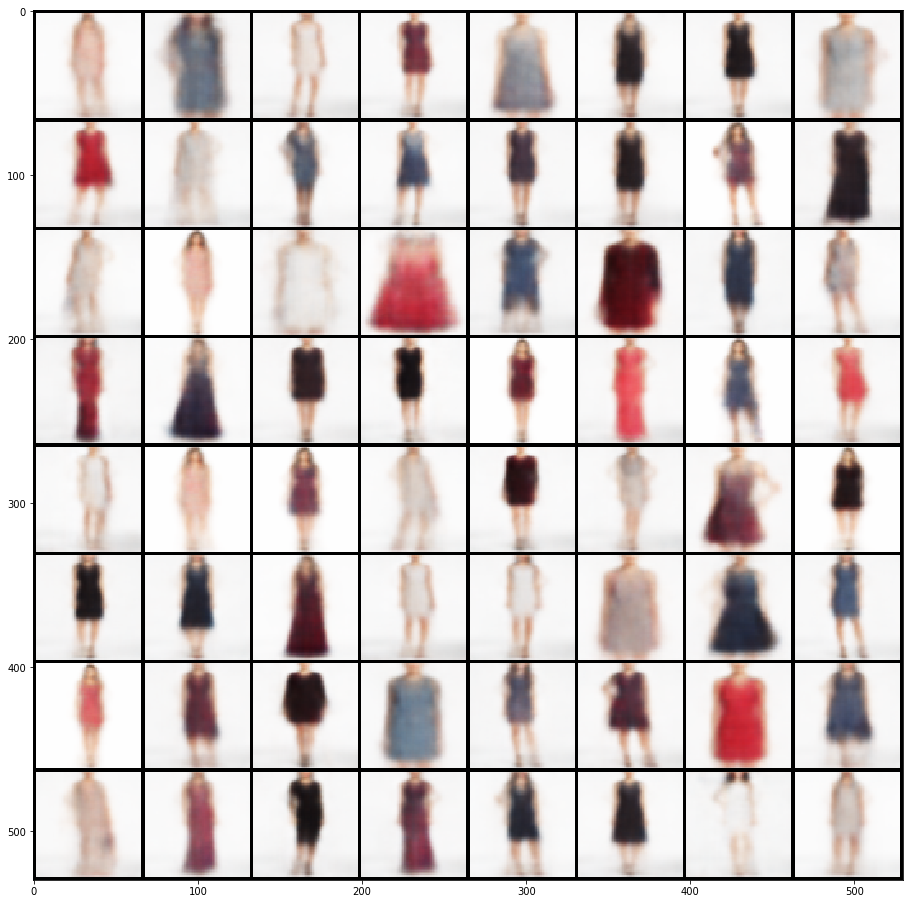

In [96]:
# Plot samples
samples = viz.samples()

plt.figure(figsize=(16,16))
#plt.imshow(samples.numpy()[0, :, :],cmap='gray');
plt.imshow(np.rot90(np.transpose(samples.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/64/e10_b20_samples.png",dpi=600)

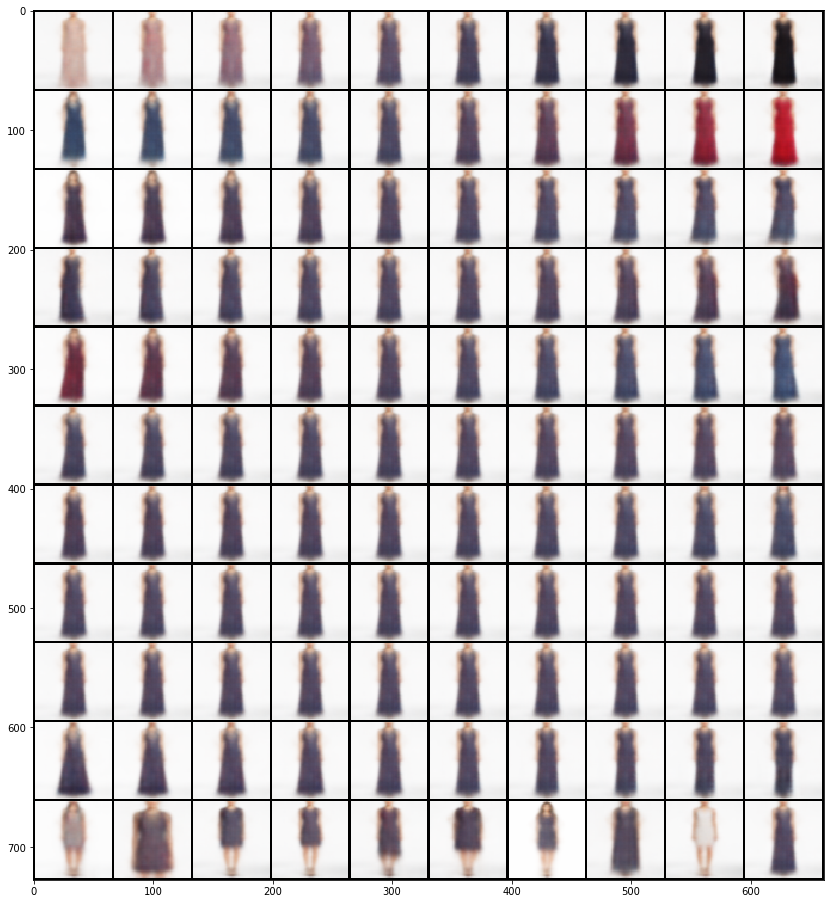

In [97]:
# Plot all traversals
traversals = viz.all_latent_traversals(size=10)

plt.figure(figsize=(16,16))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/64/e10_b20_all_traversals.png",dpi=600)

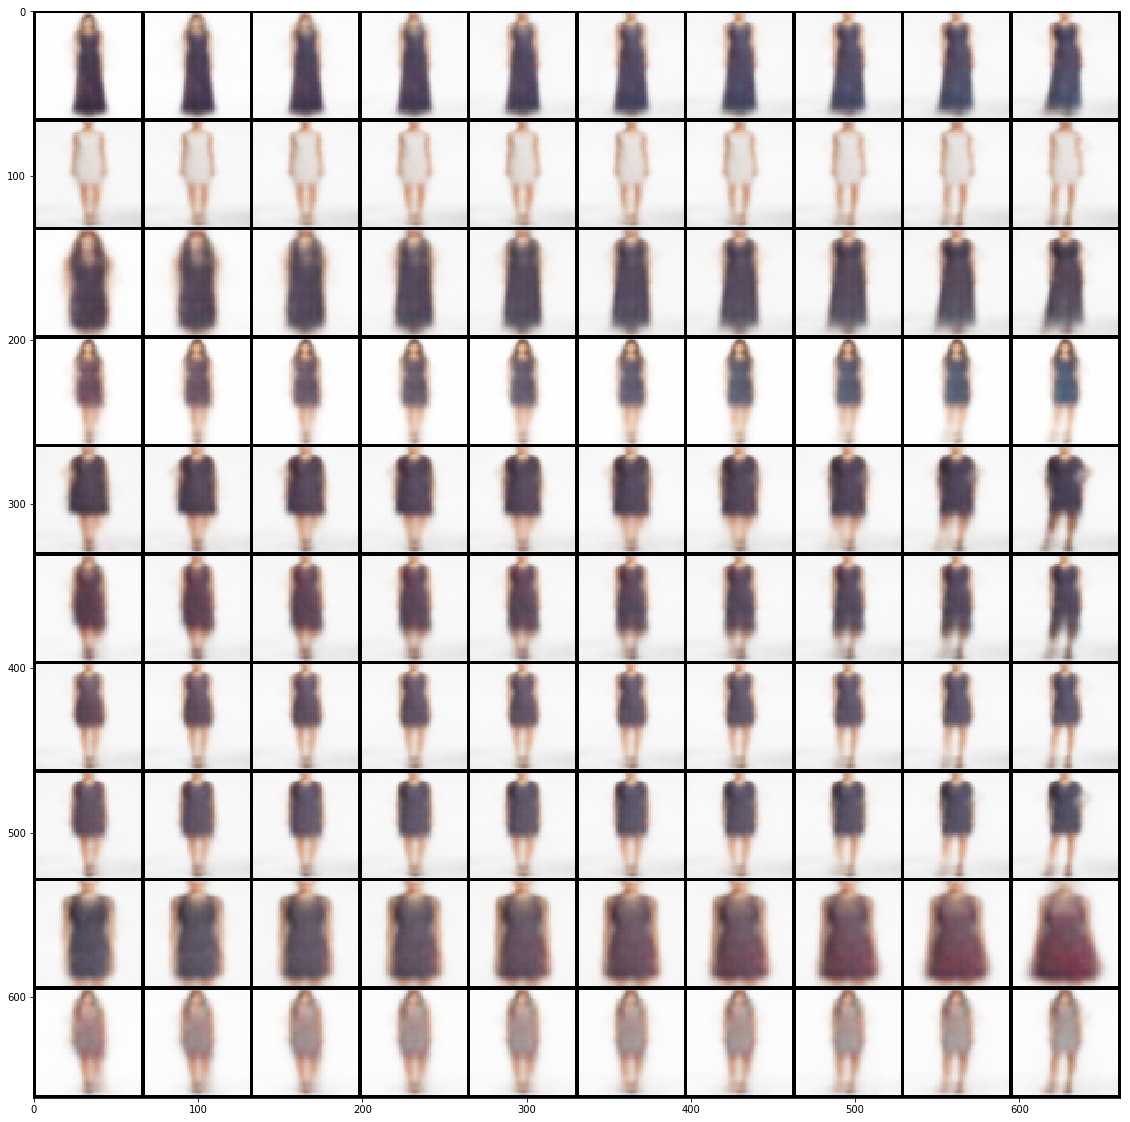

In [98]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=2, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/64/e10_b20_traversals2100.png",dpi=600)

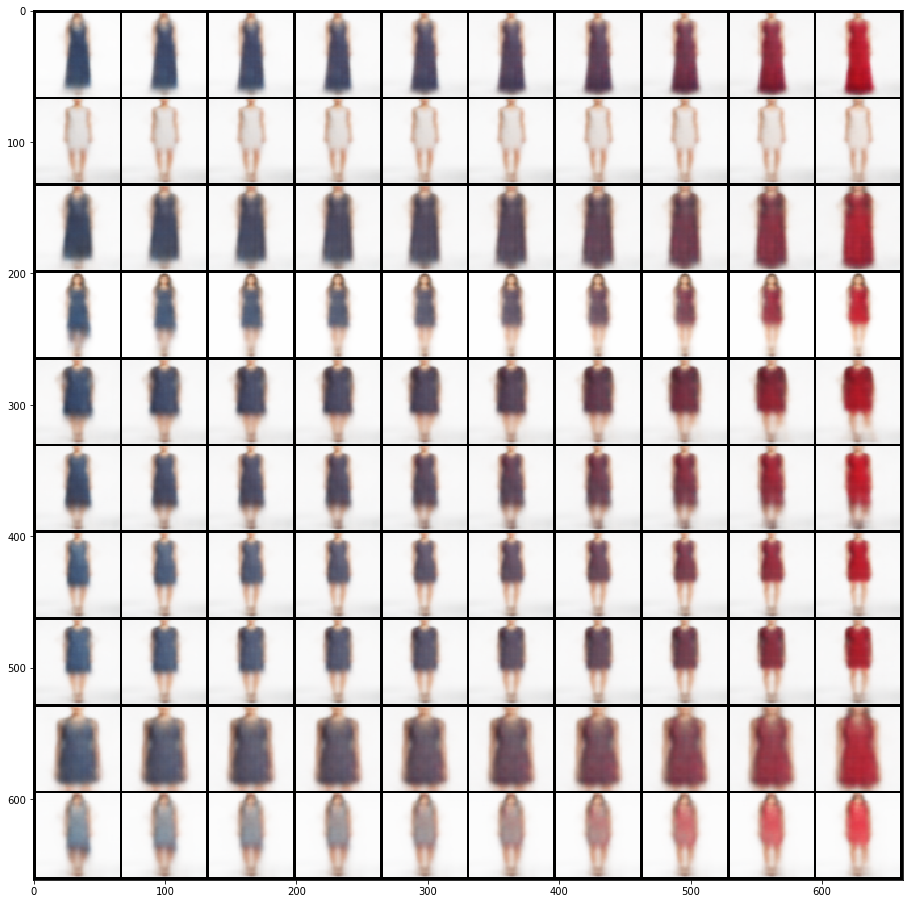

In [99]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=1, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(16,16))
plt.imshow(traversals.numpy()[0, :, :]);
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/64/e10_b20_traversals1100.png",dpi=600)

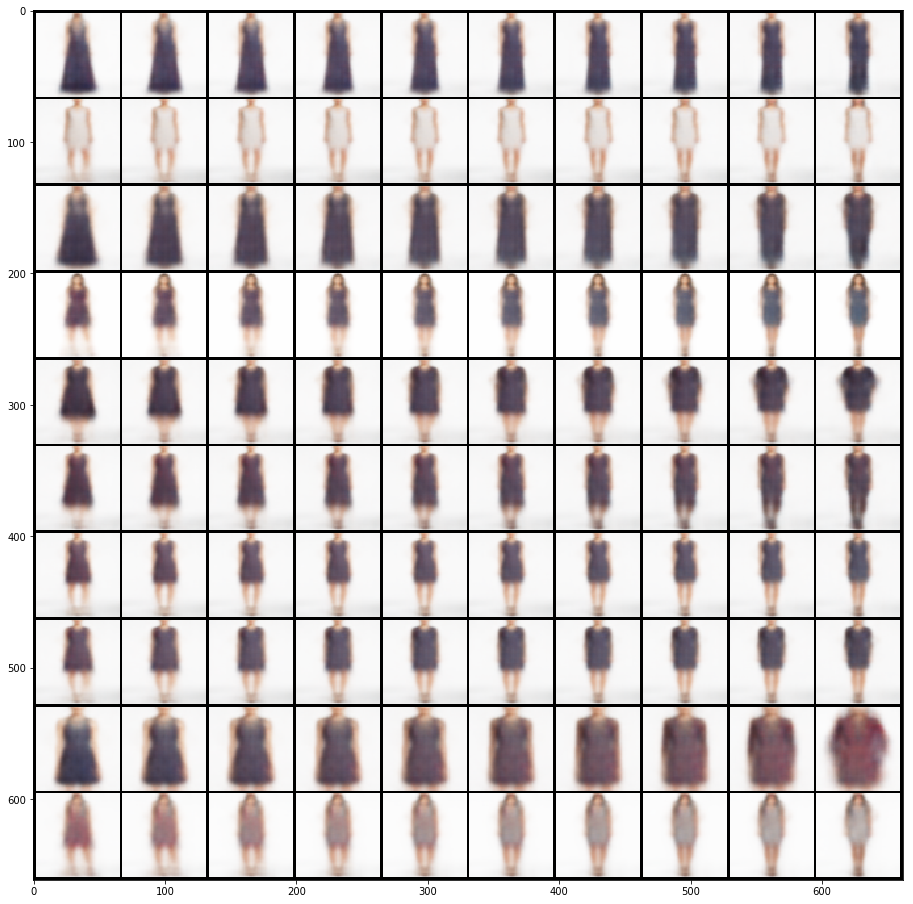

In [100]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=9, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(16,16))
#plt.imshow(traversals.numpy()[0, :, :], cmap='gray');
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/64/e10_b20_traversals9100.png",dpi=600)

### Save Model

In [101]:
model_name = "realdata64x64_e10_b20.pth"

In [102]:
torch.save(model.state_dict(),"statedict_" + model_name) # save state dict
torch.save(model, model_name) # save full model

#### Restore Model from State Dict

In [28]:
sd_model = VAE(latent_spec=latent_spec, img_size=(3, 64, 64))
sd_model.load_state_dict(torch.load("statedict_" + model_name))

#### Restore Full Model
* Note in this case the serialized data is bound to the specific classes and exact directory strucutre used.

In [ ]:
full_model = torch.load(model_name)

In [ ]:
type(full_model)

In [ ]:
type(sd_model)

In [36]:
!ls

data				requirements.txt
dataloading_pytorch_test.ipynb	statedict_jvae_fmnist_oct292018.pth
imgs				trained_models
jointvae			training.gif
jvae_fmnist_oct292018.pth	training_rd1.gif
latent_traversals.py		train_model.ipynb
load_model.ipynb		train_model_realdata_306_260_v1.ipynb
main.py				train_model_realdata_64_v1.ipynb
__pycache__			utils
RandomUtilsandTests.ipynb	viz
README.md
